In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
import random
import pandas as pd
import time
from tqdm import tqdm
from itertools import combinations
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib as mpl
import datetime
import math

In [2]:
def saturation_time(G_input, N_walkers,initial_node_with_walkers,p_out,simulation_times,initial_walker_level = 0):
    end_time_list = []
    for iter_num in range(simulation_times):
        G = G_input
        N_G_nodes = G.number_of_nodes()
        ### Asign the walker
        nx.set_node_attributes(G, [0],'history')
        if initial_walker_level == 0:
            initial_walkers = random.sample(range(N_G_nodes),initial_node_with_walkers)
            for i in initial_walkers:
                G.nodes[i]['history'] = [N_walkers / initial_node_with_walkers]
        else:
            test_l =[i for (i,j) in sorted(G.degree, key=lambda x: x[1], reverse=True)]
            selected_pool = test_l[round((initial_walker_level-1)*0.25*len(test_l)):round(initial_walker_level*0.25*len(test_l))]
            initial_walkers = random.sample(selected_pool,initial_node_with_walkers)
            for i in initial_walkers:
                G.nodes[i]['history'] = [N_walkers / initial_node_with_walkers]

        # the x (expected final distribution of walkers) of the linear regression
        walker_per_degree = N_walkers/sum([j for (i,j) in G.degree])
        degree_list = np.array([j*walker_per_degree for (i,j) in G.degree])
        degree_list = degree_list.reshape(-1,1)
        
        # Run the simulation model until the R-square over 0.99
        linear_score = [0]
        end_time = 0
        while linear_score[-1] <0.99:
            end_time += 1
            for nodes in G.nodes:
                tem_out_list = [n for n in G.neighbors(nodes)]
                tem_in_node = 0
                for neigh_node in tem_out_list:
                    tem_in_node += G.nodes[neigh_node]['history'][end_time-1] * p_out / len([n for n in G.neighbors(neigh_node)])
                G.nodes[nodes]['history'] = G.nodes[nodes]['history']+[tem_in_node + G.nodes[nodes]['history'][end_time-1] * (1-p_out)]
            ## Run the linear regression
            check_list = []
            for nodes in G.nodes:
                check_list.append(G.nodes[nodes]['history'][-1])
            reg = LinearRegression().fit(degree_list, check_list)
            linear_score.append(reg.score(degree_list, check_list))
        # record the end time of each simulation    
        end_time_list.append(end_time)
        
    return end_time_list


In [4]:
ba_ad= pd.read_csv("static-network-BA.adj", header = None, delimiter = "\s+")

In [5]:
er_ad= pd.read_csv("static-network-ER.adj", header = None, delimiter = "\s+")

In [6]:
G_er = nx.from_pandas_adjacency(er_ad)
G_ba = nx.from_pandas_adjacency(ba_ad)

In [8]:
print(nx.is_connected(G_er))

False


In [9]:
print(nx.is_connected(G_ba))

True


# Simulation

In [16]:
N_nodes =200
N_walkers = 10000
simulation_times = 100
initial_node_with_walkers = 4
p_out_list = [0.1,0.2,0.4,0.6,0.8]
percent_list = [1,2,3,4]

In [54]:
## Scale-free network
links_newnode = 3
G_sf= nx.generators.random_graphs.barabasi_albert_graph(N_nodes,links_newnode)
print('p_connection is around')
print(G_sf.number_of_edges()*2/((N_nodes-1)*N_nodes))
print('G is connected?')
print(nx.is_connected(G_sf))
print('mean degree')
print(np.mean([i for (j,i) in G_sf.degree()]))

p_connection is around
0.029698492462311557
G is connected?
True
mean degree
5.91


In [57]:
###random network
p_connection = 0.03
## create the network
G_rn = nx.fast_gnp_random_graph(N_nodes, p_connection)
print('G is connected?')
print(nx.is_connected(G_rn))
print('mean degree')
print(np.mean([i for (j,i) in G_rn.degree()]))

G is connected?
True
mean degree
6.06


In [2]:
# Scale-free network

100%|██████████| 4/4 [06:53<00:00, 103.33s/it]


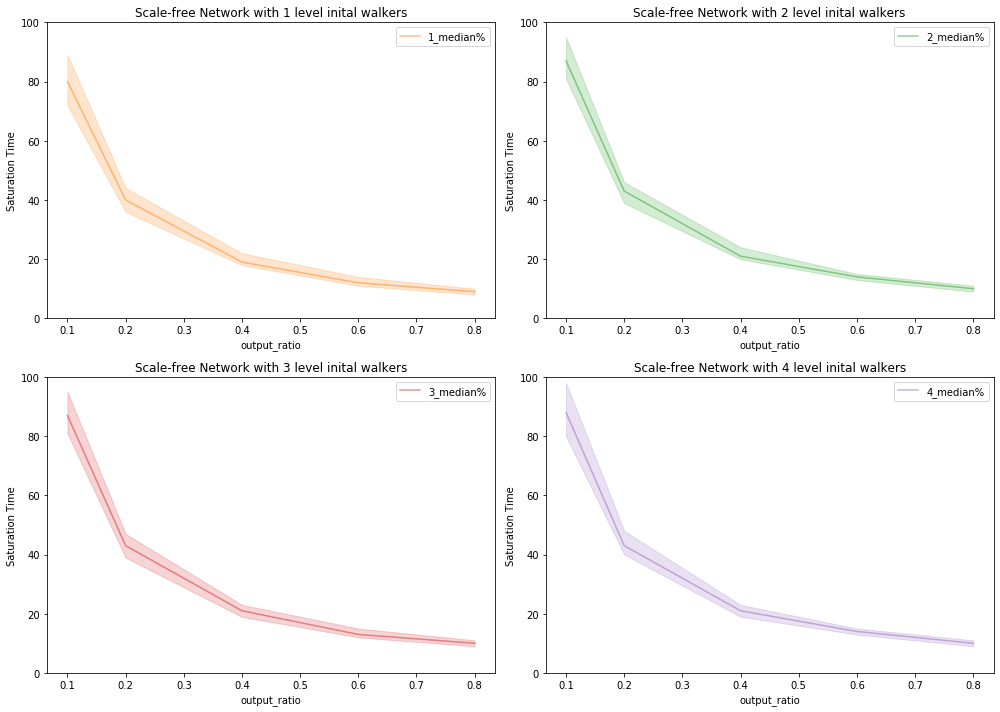

In [58]:
cmap = plt.get_cmap('tab10')
fig, ax = plt.subplots(2,2, figsize = (14,10))
for percent in tqdm(percent_list):
    list_5pre = []
    list_50pre = []
    list_95pre = []
    for p_out in p_out_list:
        output = saturation_time (G_sf, N_walkers, initial_node_with_walkers,p_out,simulation_times,percent)
        list_5pre.append(np.percentile(output, 5))
        list_50pre.append(np.percentile(output, 50))
        list_95pre.append(np.percentile(output, 95))
    ax[(percent-1)//2,(percent-1)%2].fill_between(p_out_list, list_5pre, list_95pre,color = cmap(percent),alpha = 0.2)
    ax[(percent-1)//2,(percent-1)%2].plot(p_out_list, list_50pre, label = '{}_median%'.format(percent),color = cmap(percent),alpha = 0.5)
    ax[(percent-1)//2,(percent-1)%2].legend()
    ax[(percent-1)//2,(percent-1)%2].set(ylim = (0,100),xlabel = "output_ratio",
                                         ylabel = "Saturation Time", title = "Scale-free Network with {} level inital walkers".format(percent))

plt.tight_layout()
plt.show()

In [ ]:
# random network

100%|██████████| 4/4 [08:43<00:00, 130.96s/it]


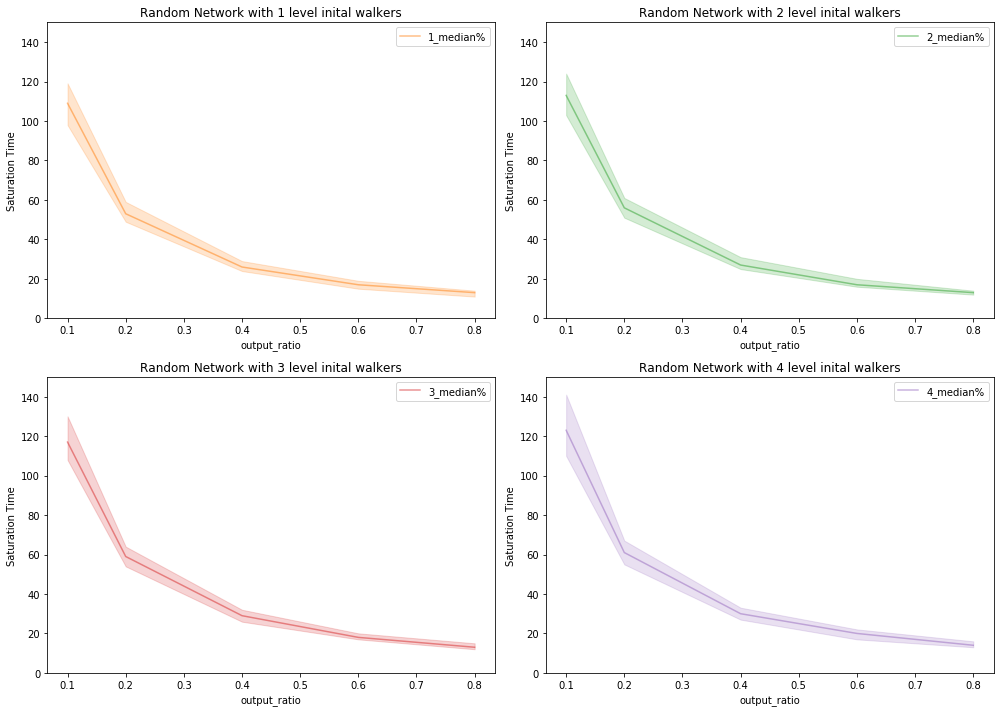

In [59]:
cmap = plt.get_cmap('tab10')
fig, ax = plt.subplots(2,2, figsize = (14,10))
for percent in tqdm(percent_list):
    list_5pre = []
    list_50pre = []
    list_95pre = []
    for p_out in p_out_list:
        output = saturation_time (G_rn, N_walkers, initial_node_with_walkers,p_out,simulation_times,percent)
        list_5pre.append(np.percentile(output, 5))
        list_50pre.append(np.percentile(output, 50))
        list_95pre.append(np.percentile(output, 95))
    ax[(percent-1)//2,(percent-1)%2].fill_between(p_out_list, list_5pre, list_95pre,color = cmap(percent),alpha = 0.2)
    ax[(percent-1)//2,(percent-1)%2].plot(p_out_list, list_50pre, label = '{}_median%'.format(percent),color = cmap(percent),alpha = 0.5)
    ax[(percent-1)//2,(percent-1)%2].legend()
    ax[(percent-1)//2,(percent-1)%2].set(ylim = (0,150),xlabel = "output_ratio",
                                         ylabel = "Saturation Time", title = "Random Network with {} level inital walkers".format(percent))

plt.tight_layout()
plt.show()

# TESTING comparsion of BA and ER 

In [12]:
###scale-free network
sf_list_5pre = []
sf_list_50pre = []
sf_list_95pre = []
p_out_list = [0.1,0.2,0.4,0.8]
links_newnode = 5
G_sf= nx.generators.random_graphs.barabasi_albert_graph(N_nodes,links_newnode)
print('p_connection is around')
print(G_sf.number_of_edges()*2/((N_nodes-1)*N_nodes))
print('G is connected?')
print(nx.is_connected(G_sf))
print('mean degree')
print(np.mean([i for (j,i) in G_sf.degree()]))

p_connection is around
0.048994974874371856
G is connected?
True
mean degree
9.75


In [15]:
###random network
p_connection = 0.01
rn_list_5pre = []
rn_list_50pre = []
rn_list_95pre = []
p_out_list = [0.1,0.2,0.4,0.8]
## create the network
G_rn = nx.fast_gnp_random_graph(N_nodes, p_connection)
print('G is connected?')
print(nx.is_connected(G_rn))
print('mean degree')
print(np.mean([i for (j,i) in G_rn.degree()]))

G is connected?
True
mean degree
10.112


In [234]:
for p_out in p_out_list:
    end_time_list = []
    for iter_num in tqdm(range(100)):
        G = G_sf
        
        ### Asign the walker
        nx.set_node_attributes(G, [0],'history')
        initial_walkers = random.sample(range(N_nodes),initial_node_with_walker)
        for i in initial_walkers:
            G.nodes[i]['history'] = [N_walkers / initial_node_with_walker]

        # the x (expected final distribution of walkers) of the linear regression
        walker_per_degree = N_walkers/sum([j for (i,j) in G.degree])
        degree_list = np.array([j*walker_per_degree for (i,j) in G.degree])
        degree_list = degree_list.reshape(-1,1)
        
        # Run the simulation model until the R-square over 0.99
        linear_score = [0]
        end_time = 0
        while linear_score[-1] <0.99:
            end_time += 1
            for nodes in G.nodes:
                tem_out_list = [n for n in G.neighbors(nodes)]
                tem_in_node = 0
                for neigh_node in tem_out_list:
                    tem_in_node += G.nodes[neigh_node]['history'][end_time-1] * p_out / len([n for n in G.neighbors(neigh_node)])
                G.nodes[nodes]['history'] = G.nodes[nodes]['history']+[tem_in_node + G.nodes[nodes]['history'][end_time-1] * (1-p_out)]
            ## Run the linear regression
            check_list = []
            for nodes in G.nodes:
                check_list.append(G.nodes[nodes]['history'][-1])
            reg = LinearRegression().fit(degree_list, check_list)
            linear_score.append(reg.score(degree_list, check_list))
        # record the end time of each simulation    
        end_time_list.append(end_time)
    
    sf_list_5pre.append(np.percentile(end_time_list, 5))
    sf_list_50pre.append(np.percentile(end_time_list, 50))
    sf_list_95pre.append(np.percentile(end_time_list, 95))


100%|██████████| 100/100 [00:08<00:00, 12.06it/s]


In [236]:
for p_out in p_out_list:
    end_time_list = []
    for iter_num in tqdm(range(100)):
        G = G_rn
        
        ### Asign the walker
        nx.set_node_attributes(G, [0],'history')
        initial_walkers = random.sample(range(N_nodes),initial_node_with_walker)
        for i in initial_walkers:
            G.nodes[i]['history'] = [N_walkers / initial_node_with_walker]

        # the x (expected final distribution of walkers) of the linear regression
        walker_per_degree = N_walkers/sum([j for (i,j) in G.degree])
        degree_list = np.array([j*walker_per_degree for (i,j) in G.degree])
        degree_list = degree_list.reshape(-1,1)
        
        # Run the simulation model until the R-square over 0.99
        linear_score = [0]
        end_time = 0
        while linear_score[-1] <0.99:
            end_time += 1
            for nodes in G.nodes:
                tem_out_list = [n for n in G.neighbors(nodes)]
                tem_in_node = 0
                for neigh_node in tem_out_list:
                    tem_in_node += G.nodes[neigh_node]['history'][end_time-1] * p_out / len([n for n in G.neighbors(neigh_node)])
                G.nodes[nodes]['history'] = G.nodes[nodes]['history']+[tem_in_node + G.nodes[nodes]['history'][end_time-1] * (1-p_out)]
            ## Run the linear regression
            check_list = []
            for nodes in G.nodes:
                check_list.append(G.nodes[nodes]['history'][-1])
            reg = LinearRegression().fit(degree_list, check_list)
            linear_score.append(reg.score(degree_list, check_list))
        # record the end time of each simulation    
        end_time_list.append(end_time)
    
    rn_list_5pre.append(np.percentile(end_time_list, 5))
    rn_list_50pre.append(np.percentile(end_time_list, 50))
    rn_list_95pre.append(np.percentile(end_time_list, 95))


100%|██████████| 100/100 [00:08<00:00, 11.45it/s]


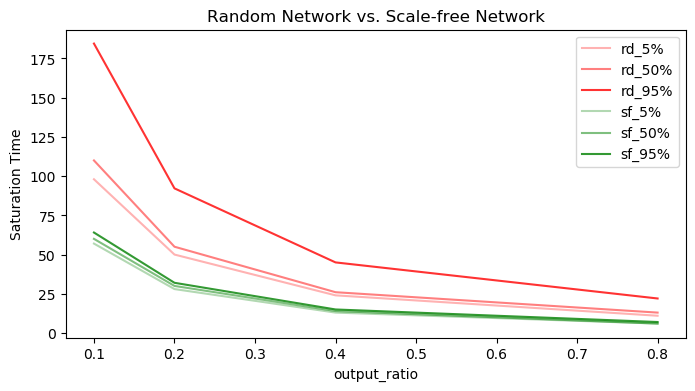

In [221]:
fig, ax = plt.subplots(1,1, figsize = (8,4))
ax.plot(p_out_list,rn_list_5pre,label = 'rd_5%',color = "red",alpha = 0.3)
ax.plot(p_out_list,rn_list_50pre, label = 'rd_50%',color = "red",alpha = 0.5)
ax.plot(p_out_list,rn_list_95pre, label = 'rd_95%',color = "red",alpha = 0.8)
ax.plot(p_out_list,sf_list_5pre,label = 'sf_5%',color = "green",alpha = 0.3)
ax.plot(p_out_list,sf_list_50pre, label = 'sf_50%',color = "green",alpha = 0.5)
ax.plot(p_out_list,sf_list_95pre, label = 'sf_95%',color = "green",alpha = 0.8)
ax.legend()
ax.set(xlabel = "output_ratio",ylabel = "Saturation Time", title = "Random Network vs. Scale-free Network")
plt.show()

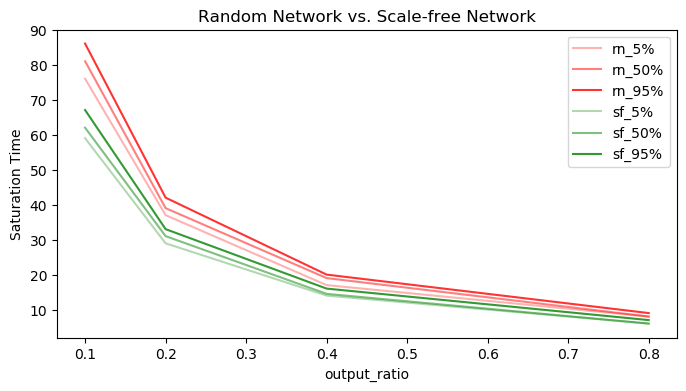

In [238]:
fig, ax = plt.subplots(1,1, figsize = (8,4))
ax.plot(p_out_list,rn_list_5pre,label = 'rn_5%',color = "red",alpha = 0.3)
ax.plot(p_out_list,rn_list_50pre, label = 'rn_50%',color = "red",alpha = 0.5)
ax.plot(p_out_list,rn_list_95pre, label = 'rn_95%',color = "red",alpha = 0.8)
ax.plot(p_out_list,sf_list_5pre,label = 'sf_5%',color = "green",alpha = 0.3)
ax.plot(p_out_list,sf_list_50pre, label = 'sf_50%',color = "green",alpha = 0.5)
ax.plot(p_out_list,sf_list_95pre, label = 'sf_95%',color = "green",alpha = 0.8)
ax.legend()
ax.set(xlabel = "output_ratio",ylabel = "Saturation Time", title = "Random Network vs. Scale-free Network")
plt.show()

# Study on NetLogo Static Graphs

In [38]:
initial_node_with_walker = 8

In [18]:
###scale-free network
sf_list_5pre = []
sf_list_50pre = []
sf_list_95pre = []
p_out_list = [0.1,0.2,0.4,0.8]
links_newnode = 5
G_sf= nx.from_pandas_adjacency(ba_ad)
N_nodes = G_sf.number_of_nodes()
print('Number of nodes: ', N_nodes)
print('p_connection is around')
print(G_sf.number_of_edges()*2/((N_nodes-1)*N_nodes))
print('G is connected?')
print(nx.is_connected(G_sf))
print('mean degree')
print(np.mean([i for (j,i) in G_sf.degree()]))

Number of nodes:  180
p_connection is around
0.06573556797020484
G is connected?
True
mean degree
11.766666666666667


In [19]:
###random network
p_connection = 0.01
rn_list_5pre = []
rn_list_50pre = []
rn_list_95pre = []
p_out_list = [0.1,0.2,0.4,0.8]
## create the network
G_rn = nx.from_pandas_adjacency(er_ad)
N_nodes = G_rn.number_of_nodes()
print('Number of nodes: ', N_nodes)
print('G is connected?')
print(nx.is_connected(G_rn))
print('mean degree')
print(np.mean([i for (j,i) in G_rn.degree()]))

Number of nodes:  180
G is connected?
False
mean degree
6.366666666666666


In [23]:
for p_out in p_out_list:
    end_time_list = []
    for iter_num in tqdm(range(100)):
        G = G_sf
        
        ### Asign the walker
        nx.set_node_attributes(G, [0],'history')
        initial_walkers = random.sample(range(N_nodes),initial_node_with_walker)
        for i in initial_walkers:
            G.nodes[i]['history'] = [N_walkers / initial_node_with_walker]

        # the x (expected final distribution of walkers) of the linear regression
        walker_per_degree = N_walkers/sum([j for (i,j) in G.degree])
        degree_list = np.array([j*walker_per_degree for (i,j) in G.degree])
        degree_list = degree_list.reshape(-1,1)
        
        # Run the simulation model until the R-square over 0.99
        linear_score = [0]
        end_time = 0
        while linear_score[-1] <0.99:
            end_time += 1
            for nodes in G.nodes:
                tem_out_list = [n for n in G.neighbors(nodes)]
                tem_in_node = 0
                for neigh_node in tem_out_list:
                    tem_in_node += G.nodes[neigh_node]['history'][end_time-1] * p_out / len([n for n in G.neighbors(neigh_node)])
                G.nodes[nodes]['history'] = G.nodes[nodes]['history']+[tem_in_node + G.nodes[nodes]['history'][end_time-1] * (1-p_out)]
            ## Run the linear regression
            check_list = []
            for nodes in G.nodes:
                check_list.append(G.nodes[nodes]['history'][-1])
            reg = LinearRegression().fit(degree_list, check_list)
            linear_score.append(reg.score(degree_list, check_list))
        # record the end time of each simulation    
        end_time_list.append(end_time)
    
    sf_list_5pre.append(np.percentile(end_time_list, 5))
    sf_list_50pre.append(np.percentile(end_time_list, 50))
    sf_list_95pre.append(np.percentile(end_time_list, 95))


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.17it/s]


In [24]:
for p_out in p_out_list:
    end_time_list = []
    for iter_num in tqdm(range(100)):
        G = G_rn
        
        ### Asign the walker
        nx.set_node_attributes(G, [0],'history')
        initial_walkers = random.sample(range(N_nodes),initial_node_with_walker)
        for i in initial_walkers:
            G.nodes[i]['history'] = [N_walkers / initial_node_with_walker]

        # the x (expected final distribution of walkers) of the linear regression
        walker_per_degree = N_walkers/sum([j for (i,j) in G.degree])
        degree_list = np.array([j*walker_per_degree for (i,j) in G.degree])
        degree_list = degree_list.reshape(-1,1)
        
        # Run the simulation model until the R-square over 0.99
        linear_score = [0]
        end_time = 0
        while linear_score[-1] <0.99:
            end_time += 1
            for nodes in G.nodes:
                tem_out_list = [n for n in G.neighbors(nodes)]
                tem_in_node = 0
                for neigh_node in tem_out_list:
                    tem_in_node += G.nodes[neigh_node]['history'][end_time-1] * p_out / len([n for n in G.neighbors(neigh_node)])
                G.nodes[nodes]['history'] = G.nodes[nodes]['history']+[tem_in_node + G.nodes[nodes]['history'][end_time-1] * (1-p_out)]
            ## Run the linear regression
            check_list = []
            for nodes in G.nodes:
                check_list.append(G.nodes[nodes]['history'][-1])
            reg = LinearRegression().fit(degree_list, check_list)
            linear_score.append(reg.score(degree_list, check_list))
        # record the end time of each simulation    
        end_time_list.append(end_time)
    
    rn_list_5pre.append(np.percentile(end_time_list, 5))
    rn_list_50pre.append(np.percentile(end_time_list, 50))
    rn_list_95pre.append(np.percentile(end_time_list, 95))


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.58it/s]


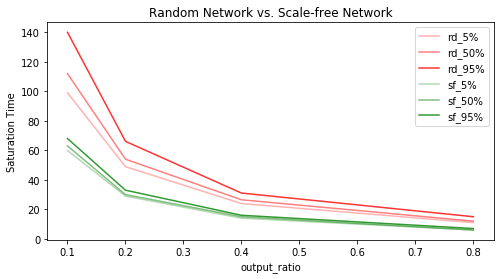

In [25]:
fig, ax = plt.subplots(1,1, figsize = (8,4))
ax.plot(p_out_list,rn_list_5pre,label = 'rd_5%',color = "red",alpha = 0.3)
ax.plot(p_out_list,rn_list_50pre, label = 'rd_50%',color = "red",alpha = 0.5)
ax.plot(p_out_list,rn_list_95pre, label = 'rd_95%',color = "red",alpha = 0.8)
ax.plot(p_out_list,sf_list_5pre,label = 'sf_5%',color = "green",alpha = 0.3)
ax.plot(p_out_list,sf_list_50pre, label = 'sf_50%',color = "green",alpha = 0.5)
ax.plot(p_out_list,sf_list_95pre, label = 'sf_95%',color = "green",alpha = 0.8)
ax.legend()
ax.set(xlabel = "output_ratio",ylabel = "Saturation Time", title = "Random Network vs. Scale-free Network")
plt.show()

# Disconnecting the BA Graph

In [60]:
ba_ad= pd.read_csv("static-network-BA.adj", header = None, delimiter = "\s+")

In [40]:
###scale-free network
sf_list_5pre = []
sf_list_50pre = []
sf_list_95pre = []
p_out_list = [0.1,0.2,0.4,0.8]
links_newnode = 5
G_sf= nx.from_pandas_adjacency(ba_ad)
N_nodes = G_sf.number_of_nodes()
print('Number of nodes: ', N_nodes)
print('p_connection is around')
print(G_sf.number_of_edges()*2/((N_nodes-1)*N_nodes))
print('G is connected?')
print(nx.is_connected(G_sf))
print('mean degree')
print(np.mean([i for (j,i) in G_sf.degree()]))

Number of nodes:  180
p_connection is around
0.06573556797020484
G is connected?
True
mean degree
11.766666666666667


In [41]:
for p_out in p_out_list:
    end_time_list = []
    for iter_num in tqdm(range(100)):
        G = G_sf
        
        ### Asign the walker
        nx.set_node_attributes(G, [0],'history')
        initial_walkers = random.sample(range(N_nodes),initial_node_with_walker)
        for i in initial_walkers:
            G.nodes[i]['history'] = [N_walkers / initial_node_with_walker]

        # the x (expected final distribution of walkers) of the linear regression
        walker_per_degree = N_walkers/sum([j for (i,j) in G.degree])
        degree_list = np.array([j*walker_per_degree for (i,j) in G.degree])
        degree_list = degree_list.reshape(-1,1)
        
        # Run the simulation model until the R-square over 0.99
        linear_score = [0]
        end_time = 0
        while linear_score[-1] <0.99:
            end_time += 1
            for nodes in G.nodes:
                tem_out_list = [n for n in G.neighbors(nodes)]
                tem_in_node = 0
                for neigh_node in tem_out_list:
                    tem_in_node += G.nodes[neigh_node]['history'][end_time-1] * p_out / len([n for n in G.neighbors(neigh_node)])
                G.nodes[nodes]['history'] = G.nodes[nodes]['history']+[tem_in_node + G.nodes[nodes]['history'][end_time-1] * (1-p_out)]
            ## Run the linear regression
            check_list = []
            for nodes in G.nodes:
                check_list.append(G.nodes[nodes]['history'][-1])
            reg = LinearRegression().fit(degree_list, check_list)
            linear_score.append(reg.score(degree_list, check_list))
        # record the end time of each simulation    
        end_time_list.append(end_time)
    
    sf_list_5pre.append(np.percentile(end_time_list, 5))
    sf_list_50pre.append(np.percentile(end_time_list, 50))
    sf_list_95pre.append(np.percentile(end_time_list, 95))


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.57it/s]


In [42]:
sf_list_5pre_connected = sf_list_5pre
sf_list_50pre_connected = sf_list_50pre
sf_list_95pre_connected = sf_list_95pre

In [87]:
G_sf= nx.from_pandas_adjacency(ba_ad)

In [88]:
random_node = int(random.uniform(0,1)*180)
print('Randomly selected node: ', random_node)
edge_to_be_removed = list(G_sf.edges(random_node))
print('Edges to be removed: ', edge_to_be_removed)

Randomly selected node:  105
Edges to be removed:  [(105, 1), (105, 6), (105, 7), (105, 16), (105, 41), (105, 43), (105, 122), (105, 136), (105, 146)]


In [89]:
nx.is_connected(G_sf)

True

In [90]:
for e in edge_to_be_removed:
    G_sf.remove_edge(e[0],e[1])

In [91]:
nx.is_connected(G_sf)

False

In [43]:
col = int(random.uniform(0,1)*180)
print('Randomly selected node: ', col)
ba_ad[col].values[:] = 0
row = col
ba_ad.loc[row] = 0

Randomly selected node:  164


In [44]:
###scale-free network
sf_list_5pre = []
sf_list_50pre = []
sf_list_95pre = []
p_out_list = [0.1,0.2,0.4,0.8]
links_newnode = 5
G_sf= nx.from_pandas_adjacency(ba_ad)
N_nodes = G_sf.number_of_nodes()
print('Number of nodes: ', N_nodes)
print('p_connection is around')
print(G_sf.number_of_edges()*2/((N_nodes-1)*N_nodes))
print('G is connected?')
print(nx.is_connected(G_sf))
print('mean degree')
print(np.mean([i for (j,i) in G_sf.degree()]))

Number of nodes:  180
p_connection is around
0.06536312849162011
G is connected?
False
mean degree
11.7


In [52]:
r_squared_distribution = []

for p_out in p_out_list:
    r_squared_distribution_p = []
    end_time_list = []
    for iter_num in tqdm(range(100)):
        G = G_sf
        
        ### Asign the walker
        nx.set_node_attributes(G, [0],'history')
        initial_walkers = random.sample(range(N_nodes),initial_node_with_walker)
        for i in initial_walkers:
            G.nodes[i]['history'] = [N_walkers / initial_node_with_walker]

        # the x (expected final distribution of walkers) of the linear regression
        walker_per_degree = N_walkers/sum([j for (i,j) in G.degree])
        degree_list = np.array([j*walker_per_degree for (i,j) in G.degree])
        degree_list = degree_list.reshape(-1,1)
        
        # Run the simulation model until the R-square over 0.99
        linear_score = [0]
        end_time = 0
        while linear_score[-1] <0.99:
            end_time += 1
            for nodes in G.nodes:
                tem_out_list = [n for n in G.neighbors(nodes)]
                tem_in_node = 0
                for neigh_node in tem_out_list:
                    tem_in_node += G.nodes[neigh_node]['history'][end_time-1] * p_out / len([n for n in G.neighbors(neigh_node)])
                G.nodes[nodes]['history'] = G.nodes[nodes]['history']+[tem_in_node + G.nodes[nodes]['history'][end_time-1] * (1-p_out)]
            ## Run the linear regression
            check_list = []
            for nodes in G.nodes:
                check_list.append(G.nodes[nodes]['history'][-1])
            reg = LinearRegression().fit(degree_list, check_list)
            linear_score.append(reg.score(degree_list, check_list))
            r_squared_distribution_p.append(reg.score(degree_list, check_list))
        # record the end time of each simulation    
        end_time_list.append(end_time)
    r_squared_distribution.append(r_squared_distribution_p)
    
    sf_list_5pre.append(np.percentile(end_time_list, 5))
    sf_list_50pre.append(np.percentile(end_time_list, 50))
    sf_list_95pre.append(np.percentile(end_time_list, 95))


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.66it/s]


In [46]:
sf_list_5pre_disconnected = sf_list_5pre
sf_list_50pre_disconnected = sf_list_50pre
sf_list_95pre_disconnected = sf_list_95pre

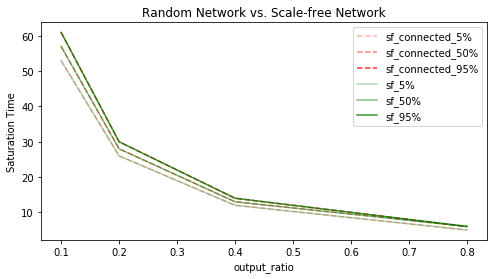

In [49]:
fig, ax = plt.subplots(1,1, figsize = (8,4))
ax.plot(p_out_list,sf_list_5pre_connected,label = 'sf_connected_5%',color = "red",alpha = 0.3,linestyle='dashed')
ax.plot(p_out_list,sf_list_50pre_connected, label = 'sf_connected_50%',color = "red",alpha = 0.5,linestyle='dashed')
ax.plot(p_out_list,sf_list_95pre_connected, label = 'sf_connected_95%',color = "red",alpha = 0.8,linestyle='dashed')
ax.plot(p_out_list,sf_list_5pre_disconnected,label = 'sf_5%',color = "green",alpha = 0.3)
ax.plot(p_out_list,sf_list_50pre_disconnected, label = 'sf_50%',color = "green",alpha = 0.5)
ax.plot(p_out_list,sf_list_95pre_disconnected, label = 'sf_95%',color = "green",alpha = 0.8)
ax.legend()
ax.set(xlabel = "output_ratio",ylabel = "Saturation Time", title = "Random Network vs. Scale-free Network")
plt.show()

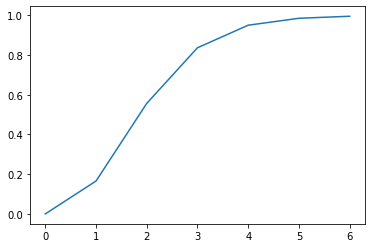

In [50]:
plt.plot(range(len(linear_score)),linear_score)

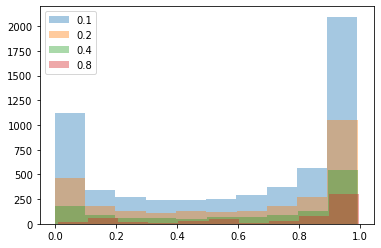

In [58]:
for j in range(len(r_squared_distribution)):
    plt.hist(r_squared_distribution[j],label=str(p_out_list[j]),alpha=0.4,density=False)

plt.legend()
plt.show()

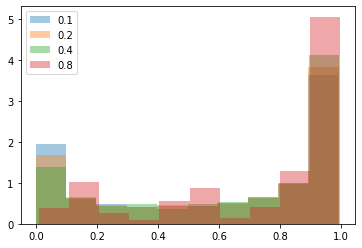

In [59]:
for j in range(len(r_squared_distribution)):
    plt.hist(r_squared_distribution[j],label=str(p_out_list[j]),alpha=0.4,density=True)

plt.legend()
plt.show()